# Bitcoin Price Analysis

Here, my objective is to analyse the bitcoin daily price database obtained from: https://finance.yahoo.com/quote/BTC-USD/history/

Initially, the daily timeframe will be the only one taken into account. In the future, I intend to analyse other timeframes like weekly or monthly data.

### 1- Pre-processing with PySpark

1.1- Creating session and reading data

In [24]:
# Importing pyspark and creating a new session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("btc") \
    .getOrCreate()
    

In [25]:
csv_file_path = "Databases/BTC/btc_usd_daily_2014_2024.csv"
data = spark.read.csv(csv_file_path, header=True)
data

DataFrame[Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

In [26]:
data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)



In [27]:
data.show()

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2014-09-17|465.864014|468.174011|452.421997|457.334015|457.334015|21056800|
|2014-09-18|456.859985|456.859985|413.104004|424.440002|424.440002|34483200|
|2014-09-19|424.102997|427.834991|384.532013|394.795990|394.795990|37919700|
|2014-09-20|394.673004|423.295990|389.882996|408.903992|408.903992|36863600|
|2014-09-21|408.084991|412.425995|393.181000|398.821014|398.821014|26580100|
|2014-09-22|399.100006|406.915985|397.130005|402.152008|402.152008|24127600|
|2014-09-23|402.092010|441.557007|396.196991|435.790985|435.790985|45099500|
|2014-09-24|435.751007|436.112000|421.131989|423.204987|423.204987|30627700|
|2014-09-25|423.156006|423.519989|409.467987|411.574005|411.574005|26814400|
|2014-09-26|411.428986|414.937988|400.009003|404.424988|404.424988|21460800|

1.2- Converting columns to their respective types

In [28]:
# importing datatypes that will be used with this database
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import to_date

In [29]:
data = data.withColumnRenamed('Adj Close','AdjClose')

In [30]:
column_names = data.columns
column_names.remove('Date')
column_names

['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']

In [31]:
# Convert columns to DoubleType
for col_name in column_names:
    data = data.withColumn(col_name, col(col_name).cast(DoubleType()))

# Convert "Date" column to DateType
data = data.withColumn("Date", to_date(data["Date"], "yyyy-MM-dd"))

In [32]:
data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- AdjClose: double (nullable = true)
 |-- Volume: double (nullable = true)



In [33]:
data = data.orderBy(data['Date'])
data.show()

+----------+----------+----------+----------+----------+----------+-----------+
|      Date|      Open|      High|       Low|     Close|  AdjClose|     Volume|
+----------+----------+----------+----------+----------+----------+-----------+
|2014-09-17|465.864014|468.174011|452.421997|457.334015|457.334015|  2.10568E7|
|2014-09-18|456.859985|456.859985|413.104004|424.440002|424.440002|  3.44832E7|
|2014-09-19|424.102997|427.834991|384.532013| 394.79599| 394.79599|  3.79197E7|
|2014-09-20|394.673004| 423.29599|389.882996|408.903992|408.903992|  3.68636E7|
|2014-09-21|408.084991|412.425995|   393.181|398.821014|398.821014|  2.65801E7|
|2014-09-22|399.100006|406.915985|397.130005|402.152008|402.152008|  2.41276E7|
|2014-09-23| 402.09201|441.557007|396.196991|435.790985|435.790985|  4.50995E7|
|2014-09-24|435.751007|   436.112|421.131989|423.204987|423.204987|  3.06277E7|
|2014-09-25|423.156006|423.519989|409.467987|411.574005|411.574005|  2.68144E7|
|2014-09-26|411.428986|414.937988|400.00

### 2- Experiments

2.1- Ploting a 2024 price chart

In [34]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

First, I will plot the daily candle chart with moving average of 10, 30 and 60 days.

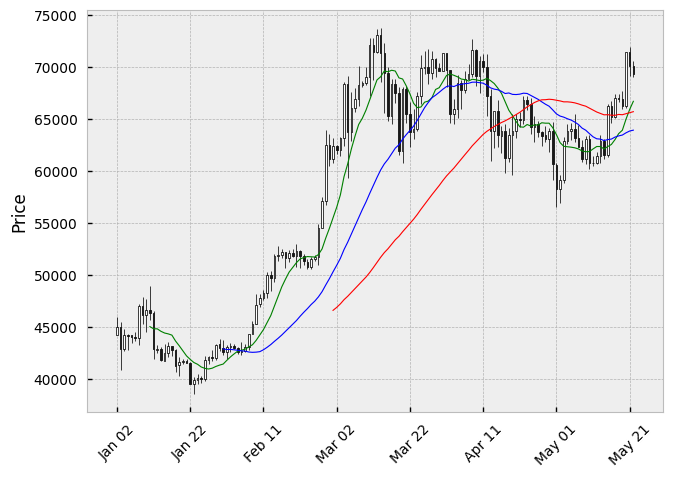

In [35]:
# Filtering current year data
current_year_data = data.where(data['Date'] > '2024-01-01')

# Changing style
mc = mpf.make_marketcolors(up='white',down='black')
style = mpf.make_mpf_style(base_mpl_style=['seaborn-v0_8-notebook','bmh'],
                           marketcolors=mc, 
                           mavcolors=['green','blue','red'])

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = current_year_data.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)
pandas_df.columns
mpf.plot(pandas_df, type='candle',mav=[10,30,60], style=style)

Now I will plot a line chart of all-time prices with moving average of 200 days. The y-axis will have a log scale.

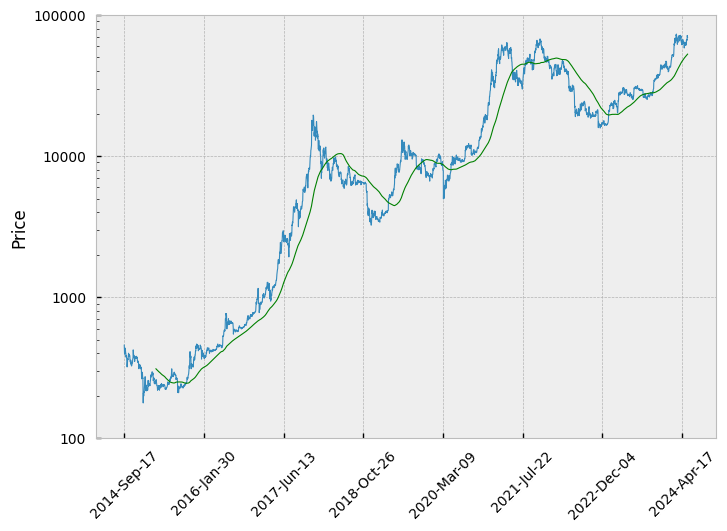

In [36]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = data.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

# Set 'Date' column as index
pandas_df.set_index('Date', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots()
mpf.plot(pandas_df, type='line',mav=[200],style=style, ax=ax)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Set y-axis limits from 100 to 100,000
ax.set_ylim(100, 100000)

# Use ScalarFormatter to display labels as plain numbers
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add a legend indicating the year
years = pandas_df.index.year.unique()
for year in years:
    ax.plot([], [], label=str(year))

plt.show()


# 1- About bitcoin generation, exponentials and logarithms
### A mathematical vision on the decreasing production of coins


Bitcoin is a well-known cryptocurrency created by the pseudonymous Satoshi Nakamoto. The core idea behind its creation was the need for a decentralized currency that could not have its value decreased by the printing of more money. One of the mechanisms that ensure this is the decreasing generation of bitcoins. In this text, we will explore the functionality that guarantees this and the mathematics behind it.

We can represent the network as a chain of blocks, each block containing confirmed transactions. Every time a new block is created, new coins are added to the network. Three basic questions come to mind: How many bitcoins are generated by each block? By how much does this quantity decrease? How often does it decrease? All these questions are answered by the code. The first block starts with the generation of 50 coins, and after every 210,000 blocks, this amount is decreased by half (the so-called Halving).



In [37]:
# Quantity of coins generated in the first block
start_amount = 50

# Number of blocks before each "halving"
blocks_between_halving = 210000

# Decreasing ratio
r = 0.5

Now that we have the main values. How this works mathematically? Lets go through this step by step.
First, we know that at the start, each block produces 50 bitcoin. So imagine that we have no ratio of decreasing. In that case, we would have a function of the block index, let's call it f(x) to simplify. This function receives a block index, x, and returns the quantity of coins created. It would look like this:

\begin{equation}
f(x) = 50
\end{equation}

Looking at this equation, we can expect that doesn't matter which block we choose, we will always have 50 generated bitcoin. But the reality is different. The actual network has a decreasing ratio every 210000 blocks. How can we write this down? We need a function that cuts by half the generation every 210000 blocks. Let's think only about 1 halving. In any block before 210000, the code generates 50 bitcoin, so f(x) works perfectly for that case. After 210000 blocks, the network will produce 25 coins per block, that is, 50 divided by 2.

\begin{equation} \tag{2}
f(x) = \begin{cases} 
50 & \text{if } x < 210,000 \\
50/2 & \text{if } x \geq 210,000 
\end{cases}
\end{equation}

Now, we're closer. But can we make those two cases almost identical? Yes! In the first case, we can divide 50 by 2 elevated by 0. Every number elevated by 0 equals 1, so the function still the same, it is just written in another way.

\begin{equation} \tag{3}
f(x) = \begin{cases} 
50/2^0 & \text{if } x < 210,000 \\
50/2^1 & \text{if } x \geq 210,000 
\end{cases}
\end{equation}

Looking at these two cases, we can unite them in a more generic function. Think in the scale of halvings, so before the first halving we would have an epoch with index "0", after the first halving the index would be "1" and so on. Imagine how the function we're trying to achieve would look if it was not about an specif block x, but about an halving i. Then we would have something like this:

\begin{equation} \tag{4}
f(i) = 50/2^i
\end{equation}

Now, if we choose a halving index, the function will give us the amount of bitcoin genereted by each block after that halving. For example, after the 1st halving, we would have 50/2 = 25 coins. After the 4th, 50/16 = 3.125 coins per block. 

But the function we wanted returns the coins generated by an specific block. In this case we need to "discover" in which epoch the block "belongs". This is not difficult. If we have the number of the block (x) then we just need to divide the number by the interval between halvings, that is 210.000. If we choose block 345.000, for example, we should calculate 345.000/210,000 = 1.642. Now we just ignore everything after the collon. So block 345.000 is in the interval of block of the first halving. Therefore, it created 25 coins. Finally, the function we want is:

\begin{equation} \tag{5}
f(x) = 50/2^{\lfloor {x/210,000} \rfloor}
\end{equation}

If you are wondering how it would look in a chart, here it is:

In [38]:
import numpy as np
import math

# Function definition
def coins_generated_by_block(x) -> float:
    """
    Calculate the number of coins generated by a given block index.

    This function receives a block index and returns the amount of coins
    it would create based on the halving interval.

    Parameters:
    x (int): The block index.

    Returns:
    float: The amount of created coins.
    """
    return 50 / 2 ** np.floor(x/210000)

In [39]:
# Blocks between epoch 0 and 9
x_values = np.linspace(0,1889999,1000)

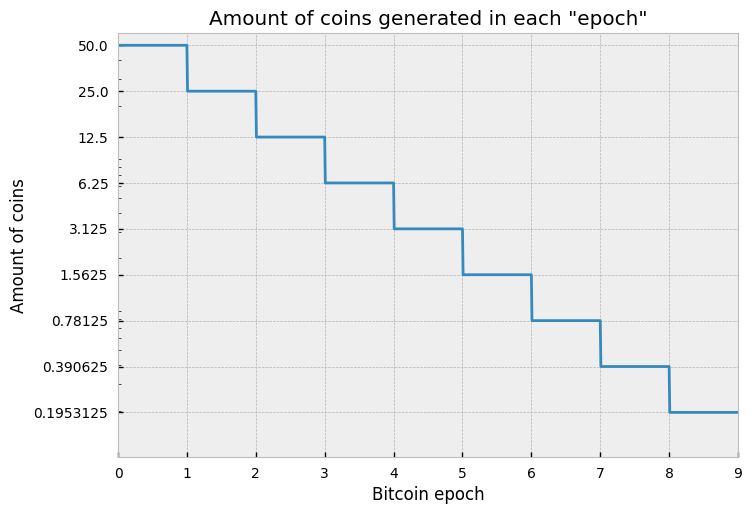

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, coins_generated_by_block(x_values))
ax.set_title('Amount of coins generated in each \"epoch\"')

# Define the desired x-ticks
x_ticks = [i for i in range(0,10*210000,210000)]
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(ticker.FixedFormatter([str(int(tick/210000)) for tick in x_ticks]))
ax.set_xlim(min(x_ticks), max(x_ticks))
ax.set_xlabel('Bitcoin epoch')

# Set y-axis to log scale
ax.set_yscale('log')

# Define the desired y-ticks
y_ticks = [50/2**i for i in range(0,10)] # Creates the list [50, 25, 12.5, 6.25, 3.125]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax.set_ylim(0.1, max(y_ticks) + 10)
ax.set_ylabel('Amount of coins')

# Saves and shows the figure on the notebook
plt.savefig('coins_per_block.png', bbox_inches='tight')
plt.show()

In [41]:
def total_of_coins(block_list):
    bitcoins_created_list = []

    # dynamic programming
    memory = []
    memory.append(50)

    for i in range(1,1890000):
        total_coins = coins_generated_by_block(i) + memory[i-1]
        memory.append(total_coins)

    for block in block_list:
        bitcoins_created_list.append(memory[int(block)])
        
    return bitcoins_created_list

In [42]:
total_of_coins = total_of_coins(x_values)

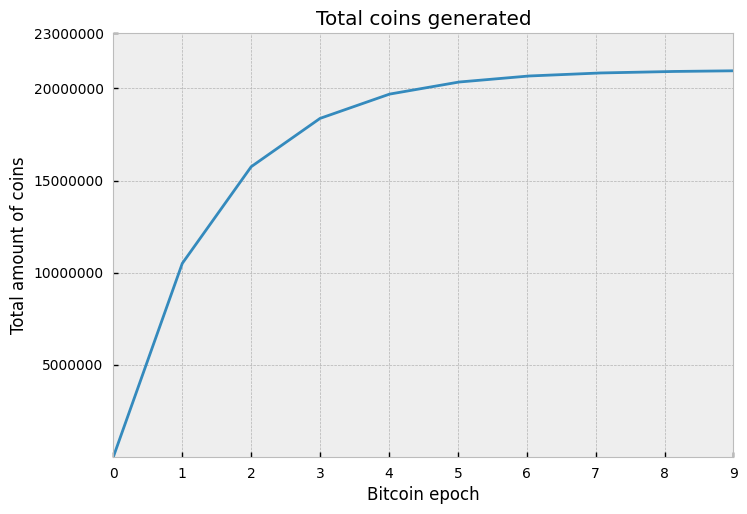

In [48]:
# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, total_of_coins)
ax.set_title('Total coins generated')

# Define the desired x-ticks
x_ticks = [i for i in range(0,10*210000,210000)]
ax.set_xticks(x_ticks)
ax.get_xaxis().set_major_formatter(ticker.FixedFormatter([str(int(tick/210000)) for tick in x_ticks]))
ax.set_xlim(min(x_ticks), max(x_ticks))
ax.set_xlabel('Bitcoin epoch')

# Define the desired y-ticks
y_ticks = [0,5000000,10000000,15000000,20000000, 23000000]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax.set_ylim(0.1, max(y_ticks) + 10)
ax.set_ylabel('Total amount of coins',)
plt.savefig('total_amount_coin.png', bbox_inches='tight')
plt.show()

\begin{equation} \tag{5}
g(x) = \sum_{j=0}^{x}{50/2^{\lfloor {j/210,000} \rfloor}}
\end{equation}

Plotting the double plot

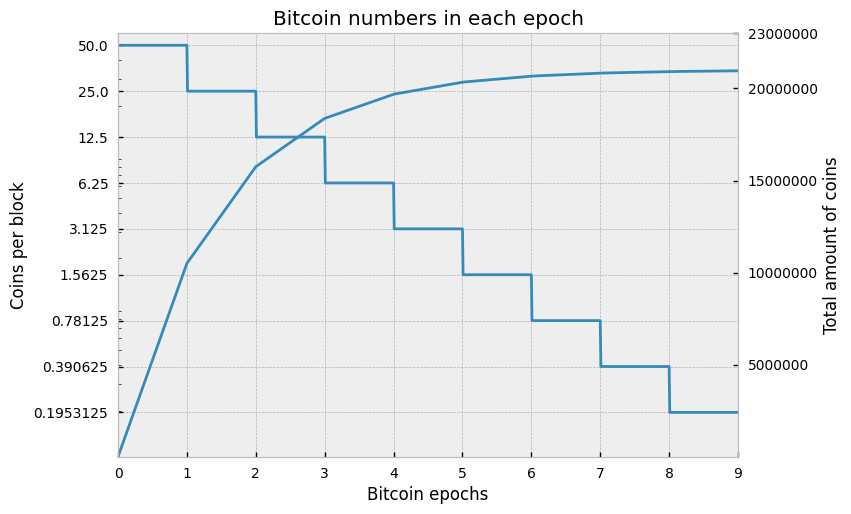

In [46]:

# Create the plot
fig, ax = plt.subplots()
ax.plot(x_values, coins_generated_by_block(x_values))
ax.set_title('Bitcoin numbers in each epoch')

# Define the desired x-ticks
x_ticks = [i for i in range(0,10*210000,210000)]
ax.set_xticks(x_ticks)
ax.set_xlabel('Bitcoin epochs')
ax.get_xaxis().set_major_formatter(ticker.FixedFormatter([str(int(tick/210000)) for tick in x_ticks]))
ax.set_xlim(min(x_ticks), max(x_ticks))

# Set y-axis to log scale
ax.set_yscale('log')

# Define the desired y-ticks
y_ticks = [50/2**i for i in range(0,10)]
ax.set_yticks(y_ticks)
ax.set_ylabel('Coins per block')
ax.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax.set_ylim(0.1, max(y_ticks) + 10)

y_ticks = [0,5000000,10000000,15000000,20000000, 23000000]
ax2 = ax.twinx()
ax2.plot(x_values, total_of_coins)
ax2.grid(False)
ax2.set_ylabel('Total amount of coins')
ax2.tick_params(axis='y')
ax2.set_yticks(y_ticks)
ax2.get_yaxis().set_major_formatter(ticker.FixedFormatter([str(tick) for tick in y_ticks]))
ax2.set_ylim(0.1, max(y_ticks) + 10)

plt.show()